In [193]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_machine_learning.neural_networks import EstimatorQNN, EffectiveDimension
from qiskit_machine_learning.connectors import TorchConnector

def build_qnn(n_qubits) : 
    feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=1)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1, entanglement='linear')
    qc = QuantumCircuit(n_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    obs = [SparsePauliOp(Pauli('Z' + 'I' * (n_qubits - 1)))]

    qnn = EstimatorQNN(
        circuit = qc,
        input_params = feature_map.parameters,
        weight_params = ansatz.parameters,
        estimator = Estimator(),
    )
    return qnn, qnn.num_weights

def compute_log_probs_grads(qnn, X, theta_np) : 
    init_theta = torch.tensor(theta_np, dtype=torch.float32)
    torch_qnn = TorchConnector(qnn, initial_weights=init_theta)

    grads = []
    for x in X : 
        x_t = torch.tensor(x, dtype=torch.float32)
        probs = torch_qnn(x_t)
        p0 = probs[0].clamp(min=1e-8)
        logp0 = torch.log(p0)
        
        grad_w, = torch.autograd.grad(
            logp0,
            torch_qnn._weights,                     # ← weight parameter
            retain_graph=False,
            allow_unused=False
        )
        grads.append(grad_w.detach().cpu().numpy())
    return np.vstack(grads)

def fisher_eigenvalues(grads) : 
    fim = grads.T @ grads / grads.shape[0]
    eigs = np.linalg.eigvals(fim)
    return np.sort(eigs)[::-1]

if __name__ == '__main__' : 
    sample_size = 750
    results = []

    for n_qubits in [8, 11, 14] : 
        print(f'\n>>> {n_qubits} qubits')
        qnn, num_params = build_qnn(n_qubits)

        X = np.random.uniform(0, 1, size=(sample_size, n_qubits))
        theta0 = np.random.uniform(-np.pi, np.pi, size=(num_params, ))

        grads = compute_log_probs_grads(qnn, X, theta0)

        eigvals = fisher_eigenvalues(grads)
        print('Fisher eigenvalues:', eigvals)

        ed_calc = EffectiveDimension(
            qnn=qnn,
            weight_samples=num_params,
            input_samples=n_qubits
        )
        ed = ed_calc.get_effective_dimension(dataset_size=sample_size)
        print(f'number of weights = {num_params}, ED = {ed:.4f}, normalized = {ed / num_params:.4f}')

        results.append({
            'n_qubits': n_qubits,
            'fisher_eigvals': eigvals,
            'ED': ed,
            'normalized_ED': ed / num_params
        })        


>>> 8 qubits


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_9493/2151579.py:22: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(),
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_9493/2151579.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Fisher eigenvalues: [166.72217    97.07688    55.913723   52.23465    43.064907   31.928005
  24.408154   16.163515   13.790872    9.840891    9.678327    7.1581798
   5.8372436   3.21663     2.3143084   1.2147013]
number of weights = 16, ED = 9.0698, normalized = 0.5669

>>> 11 qubits


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_9493/2151579.py:22: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(),
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_9493/2151579.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTe

Fisher eigenvalues: [3.1355806e+03 2.4490613e+02 9.7893959e+01 7.3195572e+01 4.8832146e+01
 4.0391644e+01 3.5605537e+01 3.4997166e+01 2.1264141e+01 1.9395800e+01
 1.8338034e+01 1.5134655e+01 1.1938050e+01 9.9074869e+00 9.3551884e+00
 7.9515901e+00 5.7390957e+00 4.9694147e+00 3.8943057e+00 3.5893459e+00
 2.7384429e+00 1.1142331e+00]
number of weights = 22, ED = 12.5195, normalized = 0.5691

>>> 14 qubits


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_9493/2151579.py:22: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator(),
/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_9493/2151579.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(
/opt/anaconda3/envs/myenv/lib/python3.13/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTe

Fisher eigenvalues: [346.31073    208.33015     72.9539      63.639065    41.008347
  29.545017    25.263245    22.953924    18.427391    16.125776
  14.539372    13.044581    10.976768     9.285286     7.9945035
   6.818163     6.5713744    5.366359     4.8889995    4.2531705
   3.2689261    2.4721313    2.2308066    1.9794748    1.7527424
   1.5641229    1.2030932    0.79487175]
number of weights = 28, ED = 16.0738, normalized = 0.5741


/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_9493/2944229620.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(eigenvalue_lists, labels=qubit_labels, showfliers=False)


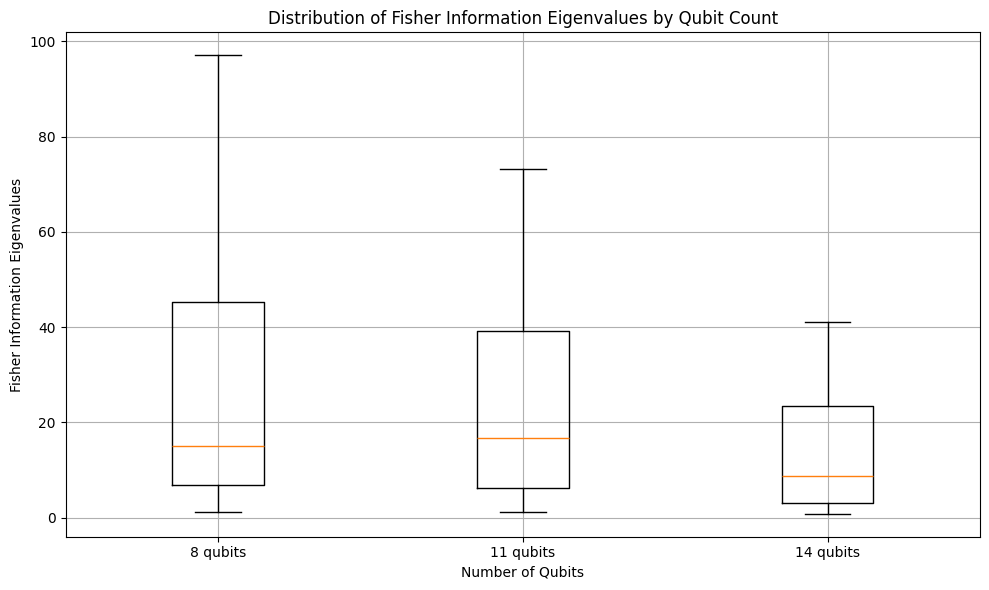

In [194]:
eigenvalue_lists = [result['fisher_eigvals'] for result in results]
qubit_labels = [f"{result['n_qubits']} qubits" for result in results]

plt.figure(figsize=(10, 6))
plt.boxplot(eigenvalue_lists, labels=qubit_labels, showfliers=False)
plt.xlabel("Number of Qubits")
plt.ylabel("Fisher Information Eigenvalues")
plt.title("Distribution of Fisher Information Eigenvalues by Qubit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [195]:
eight_qubits_eigvals = np.array(eigenvalue_lists[0])
eleven_qubits_eigvals = np.array(eigenvalue_lists[1])
fourteen_qubits_eigvals = np.array(eigenvalue_lists[2])

In [196]:
print(f'mean = {np.median(eight_qubits_eigvals)}, std = {np.std(eight_qubits_eigvals)}')
print(f'mean = {np.median(eleven_qubits_eigvals)}, std = {np.std(eleven_qubits_eigvals)}')
print(f'mean = {np.median(fourteen_qubits_eigvals)}, std = {np.std(fourteen_qubits_eigvals)}')

mean = 14.977193832397461, std = 42.59266662597656
mean = 16.736343383789062, std = 648.1640625
mean = 8.639894485473633, std = 72.22811889648438
